# EDA and Feature Engineering

### Loading the cleaned CSVs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import time

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train=pd.read_csv('datasets/clean_train.csv')
test=pd.read_csv('datasets/clean_test.csv')

In [3]:
train.head()
train=train.drop('Unnamed: 0',axis=1)

In [4]:
train.shape

(2041, 190)

In [5]:
test=test.drop('Unnamed: 0',axis=1)

# Exploratory Data Analysis

In [6]:
def subplot_scatterplots(dataframe, col1, list_of_col2, list_of_xlabels, list_of_ylabels):
    list_of_col1=list_of_col2
    list_of_col2=[col1 for x in list_of_col2]
    list_of_xlabels=list_of_col2
    list_of_ylabels=list_of_col2
    list_of_xlabels=list_of_col1
    nrows = int(np.ceil(len(list_of_col1)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(13,4*nrows)) # You'll want to specify your figsize
    fig.tight_layout()
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    
    for i, column in enumerate(list_of_col1): # Gives us an index value to get into all our lists
        legend=dataframe.corr()[column][(list_of_col2[i])]
        
        scatter=sns.scatterplot(dataframe[column],dataframe[list_of_col2[i]],ax=ax[i],label='Correlation= ' + str(legend))
        regline=sns.regplot(dataframe[column],dataframe[list_of_col2[i]],ax=ax[i],label='Regression Line') 
        ax[i].set_title('{} vs {}'.format(column,list_of_col2[i]),fontsize=14,pad=20)
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel(list_of_ylabels[i])
        
        plt.legend(['Correlation= '+str(legend)],fontsize='medium',loc='best')

        # feel free to add more settings
        # Set titles, labels, etc here for each subplot


In [7]:
def test_assoc(col1,col2,df,combine=False):

    if col1=='SalePrice':
        return 
    if col2=='SalePrice':
        return 
    assoc=pd.DataFrame()
    assoc['SalePrice']=df['SalePrice'].values
    assoc[col1]=df[col1]
    assoc[col2]=df[col2]
    
    assoc[col1+col2]=df[col1]*df[col2]
    
    corr=assoc.corr().apply(lambda x: abs(x))
    corr1=corr['SalePrice'][col1]
    corr2=corr['SalePrice'][col2]
    corr3=corr['SalePrice'][col1+col2]
    #values
    print('{}:{}\n{}:{}\n{}*{}:{}'.format(col1,corr1,col2,corr2,col1,col2,corr3))
    if combine:
        df[col1+col2]=assoc[col1+col2]
    return assoc[col1+col2]

In [8]:
Garages=train.columns[[('Garage' in x) for x in train.columns]]
Garages

Index(['Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
       'Garage Qual', 'Garage Cond', 'Garage Type_Out'],
      dtype='object')

In [9]:
test_assoc('Garage Area','Garage Yr Blt',train)

Garage Area:0.6503192561052052
Garage Yr Blt:0.5522732984302893
Garage Area*Garage Yr Blt:0.6576328295880213


0        938600.0
1       1116323.0
2        480438.0
3        802800.0
4        947188.0
5       1136348.0
6       1052625.0
7       1040229.0
8        819840.0
9        992376.0
10       520344.0
11      1267160.0
12      1094400.0
13       960000.0
14      1224270.0
15      1250496.0
16       982908.0
17       942240.0
18      1043856.0
19      1233526.0
20       885600.0
21       998000.0
22      1152875.0
23       836640.0
24      1118260.0
25      1039330.0
26       662928.0
27       464880.0
28            0.0
29      1153728.0
          ...    
2011    1146860.0
2012    1063260.0
2013     970420.0
2014    1088450.0
2015    1348032.0
2016     508728.0
2017          0.0
2018     999744.0
2019    1846440.0
2020     754176.0
2021     985500.0
2022     935121.0
2023    1056159.0
2024    1150272.0
2025     484344.0
2026    1568692.0
2027     868560.0
2028     864600.0
2029          0.0
2030    1302651.0
2031    1454178.0
2032          0.0
2033     420763.0
2034    1047375.0
2035    15

In [10]:
def larger(col1,col2,df):
    
    df['late_const']=df[col1].where(df[col1]>df[col2],df[col2])

In [11]:
def dropnacols(inp):
    for column in inp.columns:
        if inp[column].isnull().sum() ==len(inp.columns)-1:
            inp=inp.drop(column,axis=1)
            inp=inp.drop(column,axis=0)
    return inp

In [12]:
def drop_col(col1,col2,df):

    if col1=='SalePrice':
        return 
    if col2=='SalePrice':
        return 
    assoc=pd.DataFrame()
    assoc['SalePrice']=df['SalePrice'].values
    assoc[col1]=df[col1]
    assoc[col2]=df[col2]
    corr=assoc.corr().apply(lambda x: abs(x))
    #values
    corr1=corr[col1]['SalePrice']
    corr2=corr[col2]['SalePrice']

    if corr1 > corr2:
        return col2
    else:
        return col1


In [13]:
def the_drop(train,test,tol,drop=True):
    heat=train.corr()
    s=heat[(abs(heat)>tol)].unstack()
    s=s[(s==s)&(s!=1.0)].sort_values(ascending=False)
    dropper=[]
    for index,x in enumerate(s.index):
        if index%2==0:
            dropper.append(drop_col(x[0],x[1],train))
    print(len(dropper))

    print(train.shape)
    if drop:
        dropper=[i for i in dropper if i]
        train.drop(columns=dropper,inplace=True)
        test.drop(columns=dropper,inplace=True)
    print(train.shape)
    print (pd.DataFrame(s))

In [14]:
#splitting into numerical and dummy variables
train_num=train.iloc[:,0:59]
train_dummy=train.iloc[:,58:]

In [15]:
#subplot_scatterplots(train,'SalePrice', list(train_num.columns),'SalePrice',list(train_num.columns))

In [16]:
#subplot_scatterplots(train,'SalePrice', list(train_dummy.columns),'SalePrice',list(train_dummy.columns))

In [17]:
train_num.columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch SF',
       'Screen Porch SF', 'Pool Area', 'Pool QC', 'Fence', 'Misc Val',
       'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [18]:
train_dummy.columns.values

array(['SalePrice', '>4000SF', 'MS Zoning_C (all)', 'MS Zoning_FV',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL',
       'MS Zoning_RM', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave',
       'Lot Shape_IR2', 'Lot Shape_IR3', 'Lot Shape_Reg',
       'Land Contour_HLS', 'Land Contour_Low', 'Land Contour_Lvl',
       'Utilities_NoSeWa', 'Utilities_NoSewr', 'Lot Config_NotCulDSac',
       'Land Slope_Mod', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Greens', 'Neighborhood_GrnHill',
       'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawy

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Text(0.5, 10.0, 'Correlation between the numeric values of the training dataset')

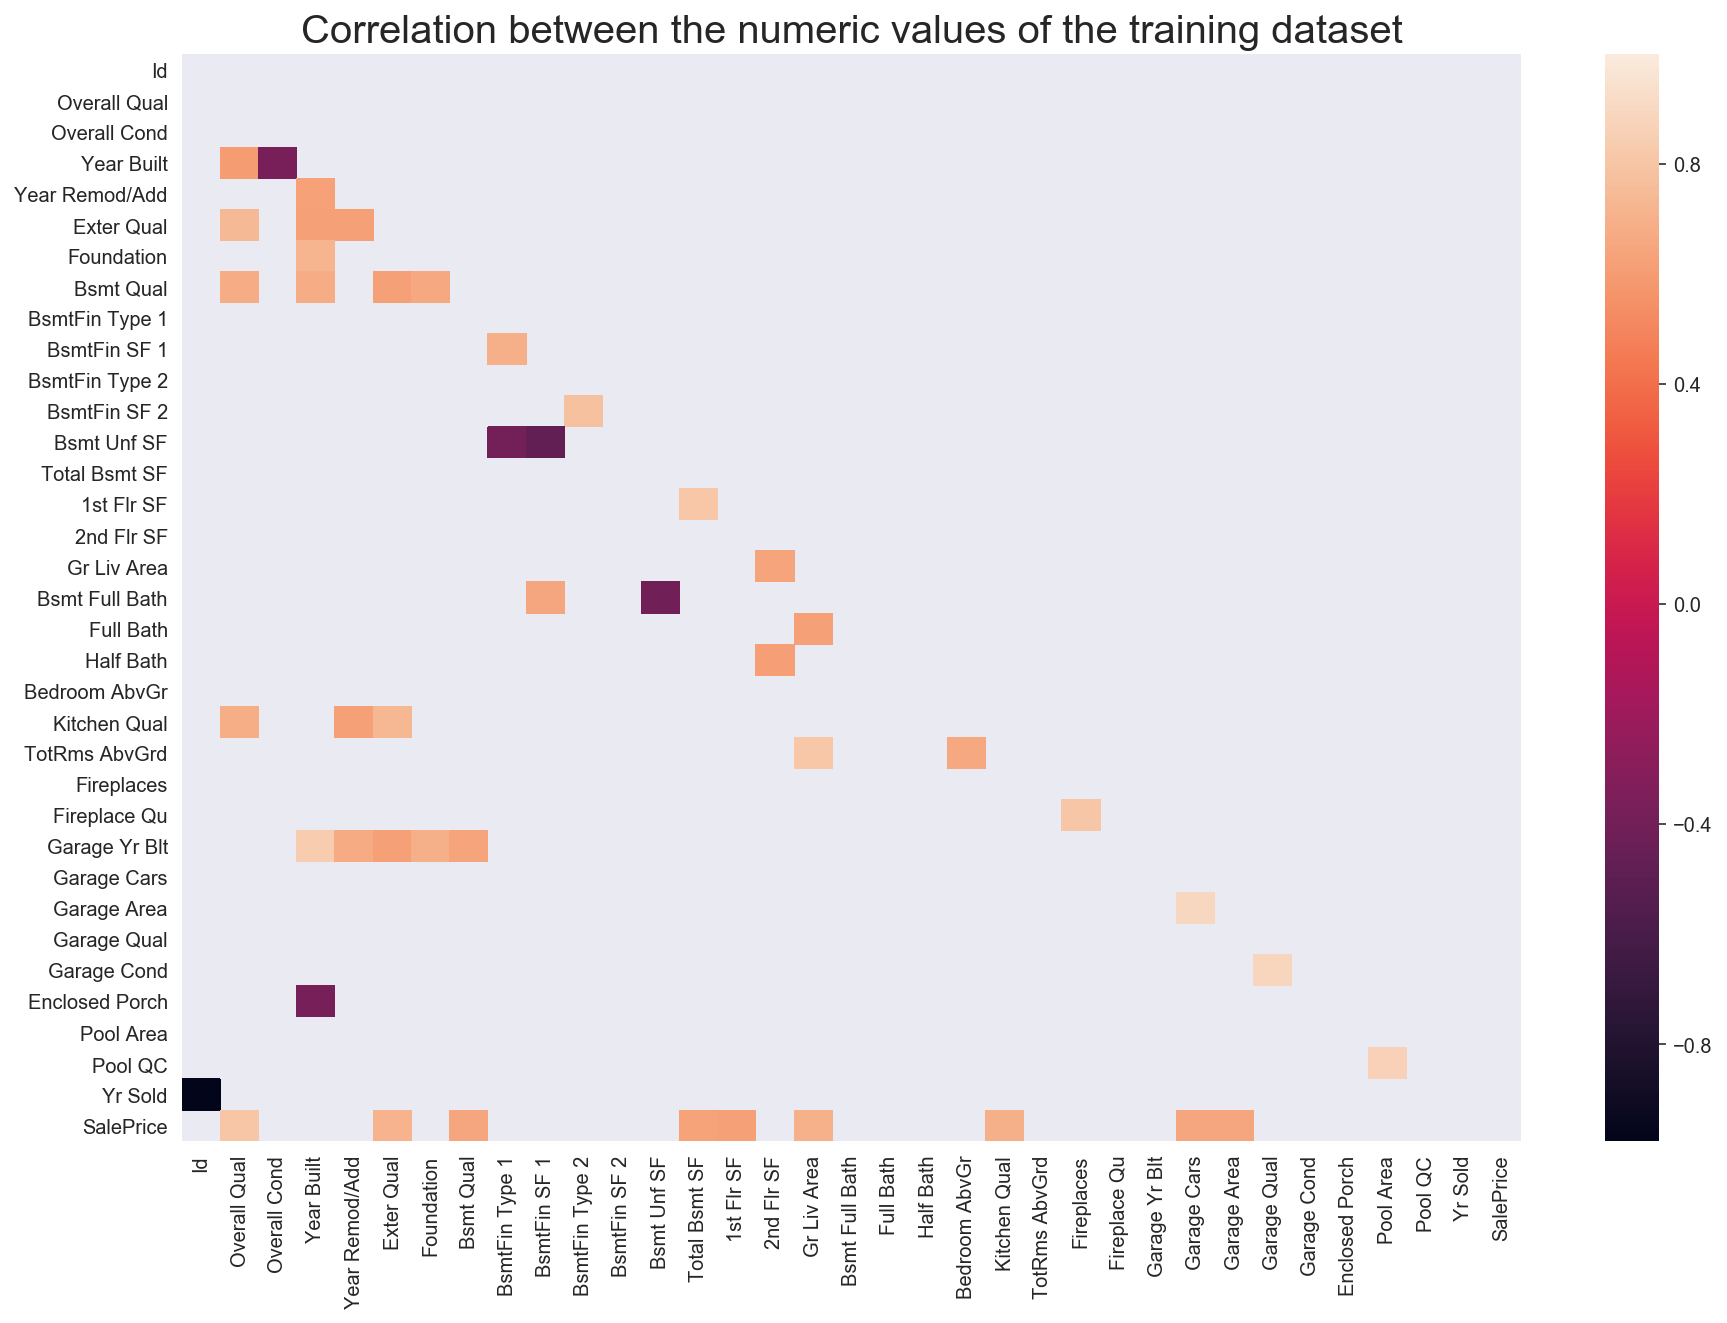

In [19]:
#plot a triangular heatmap of the numerical columns correlations that are above 0.6 or below-0.35
plt.figure(figsize=(15,10))
heat=train_num.corr()#.apply(lambda x: abs(x))
inp=heat[(heat<-0.35)+(heat>0.6)]
inp=dropnacols(inp)
mask = np.zeros_like(inp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(inp,mask=mask)
plt.gca().set_title('Correlation between the numeric values of the training dataset',size=20,y=10.0)



### Drop the collinear variables over 0.85

In [20]:
the_drop(train,test,0.85,drop=False)

11
(2041, 190)
(2041, 190)
                                                  0
Exterior 1st_CemntBd Exterior 2nd_CmentBd  0.988376
Exterior 2nd_CmentBd Exterior 1st_CemntBd  0.988376
Exterior 1st_VinylSd Exterior 2nd_VinylSd  0.977437
Exterior 2nd_VinylSd Exterior 1st_VinylSd  0.977437
Exterior 2nd_MetalSd Exterior 1st_MetalSd  0.976322
Exterior 1st_MetalSd Exterior 2nd_MetalSd  0.976322
Garage Cars          Garage Area           0.892940
Garage Area          Garage Cars           0.892940
Exterior 2nd_HdBoard Exterior 1st_HdBoard  0.885786
Exterior 1st_HdBoard Exterior 2nd_HdBoard  0.885786
Garage Cond          Garage Qual           0.884741
Garage Qual          Garage Cond           0.884741
Neighborhood_Somerst MS Zoning_FV          0.878434
MS Zoning_FV         Neighborhood_Somerst  0.878434
Pool QC              Pool Area             0.867748
Pool Area            Pool QC               0.867748
Exterior 1st_Wd Sdng Exterior 2nd_Wd Sdng  0.860528
Exterior 2nd_Wd Sdng Exterior 1st_Wd 

In [21]:
the_drop(train,test,0.85,drop=True)

11
(2041, 190)
(2041, 179)
                                                  0
Exterior 1st_CemntBd Exterior 2nd_CmentBd  0.988376
Exterior 2nd_CmentBd Exterior 1st_CemntBd  0.988376
Exterior 1st_VinylSd Exterior 2nd_VinylSd  0.977437
Exterior 2nd_VinylSd Exterior 1st_VinylSd  0.977437
Exterior 2nd_MetalSd Exterior 1st_MetalSd  0.976322
Exterior 1st_MetalSd Exterior 2nd_MetalSd  0.976322
Garage Cars          Garage Area           0.892940
Garage Area          Garage Cars           0.892940
Exterior 2nd_HdBoard Exterior 1st_HdBoard  0.885786
Exterior 1st_HdBoard Exterior 2nd_HdBoard  0.885786
Garage Cond          Garage Qual           0.884741
Garage Qual          Garage Cond           0.884741
Neighborhood_Somerst MS Zoning_FV          0.878434
MS Zoning_FV         Neighborhood_Somerst  0.878434
Pool QC              Pool Area             0.867748
Pool Area            Pool QC               0.867748
Exterior 1st_Wd Sdng Exterior 2nd_Wd Sdng  0.860528
Exterior 2nd_Wd Sdng Exterior 1st_Wd 

In [22]:
train.to_csv('datasets/train_delin.csv')
test.to_csv('datasets/test_delin.csv')

In [23]:
train.columns[[('Qual' in x) for x in train.columns]]

Index(['Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Low Qual Fin SF',
       'Kitchen Qual', 'Garage Qual'],
      dtype='object')

# Regression Preprocessing

In [24]:
#get the polynomial features
target = 'SalePrice'
nc = [x for x in train.columns if x != target]

X_train,X_test,y_train,y_test=train_test_split(train[nc],train[target])

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test= ss.transform(X_test)
test=test.drop('SalePrice',axis=1)
test_sc=ss.transform(test)
X=ss.transform(train[nc])
y=train[target]



#pf = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
#X_train_poly=pf.fit_transform(X_train)
#X_test_poly=pf.fit_transform(test)
#X_train_poly.shape

In [25]:
X_train.shape

(1530, 178)

In [26]:
y_train.shape

(1530,)

In [27]:
X_test.shape

(511, 178)

In [28]:
y_test.shape

(511,)

In [29]:
#try naive MLR for a baseline performance


In [30]:
lr=LinearRegression()
model=lr.fit(X_train,y_train)
score=model.score(X_test,y_test)



In [31]:
score

-4498453540370.622

In [32]:
cross_val_score(lr,X_train,y_train,cv=10).mean()

-4.146234400228935e+25

##### We can see from the cross_val_score that variance is very high. We try lasso to see if we can reduce the complexity and thus variance of the predictions

In [33]:
l_alphas = np.logspace(2, 6, 100)
lasso_model = Lasso(alpha=1000,max_iter=10000000)
#lasso_model = LassoCV(alphas=l_alphas, cv=10,max_iter=100000, fit_intercept=True)
lasso_model = lasso_model.fit(X_train, y_train)

In [34]:
len(test.columns[[(item>0)for column,item in zip(test.columns,lasso_model.coef_)]])

43

In [35]:
lasso_model.alpha

1000

In [36]:
#lasso_model = Lasso(alpha=alpha)

In [37]:
cross_val_score(lasso_model,X_train,y_train,cv=15).mean()

0.8586671440880733

In [38]:
cross_val_score(lasso_model,X_train,y_train,cv=10)

array([0.92315918, 0.8991769 , 0.89515846, 0.52640483, 0.87811263,
       0.91365482, 0.91876668, 0.89880611, 0.9354447 , 0.88021283])

In [39]:
lasso_model = lasso_model.fit(X_train,y_train)

In [40]:
train_predictions=lasso_model.predict(X_train)

In [41]:
test_predictions=lasso_model.predict(X_test)

In [42]:
X_test.shape

(511, 178)

0.9166738308774152

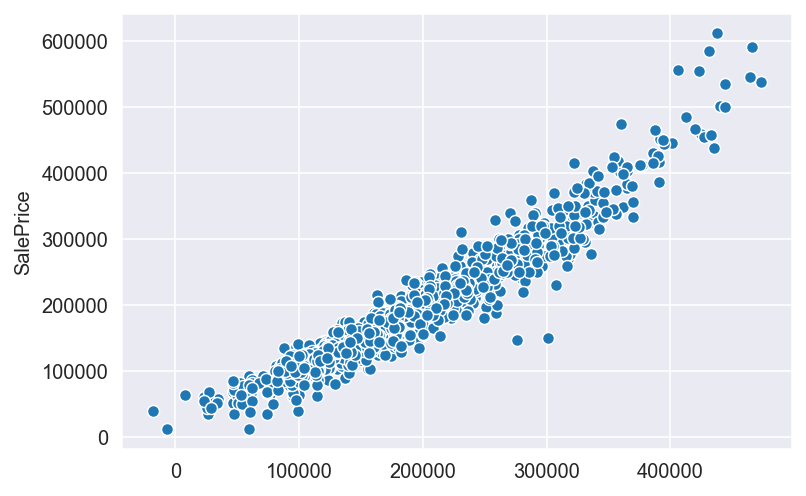

In [43]:
sns.scatterplot(train_predictions,y_train)
lasso_model.score(X_train,y_train)

0.9062996830440936

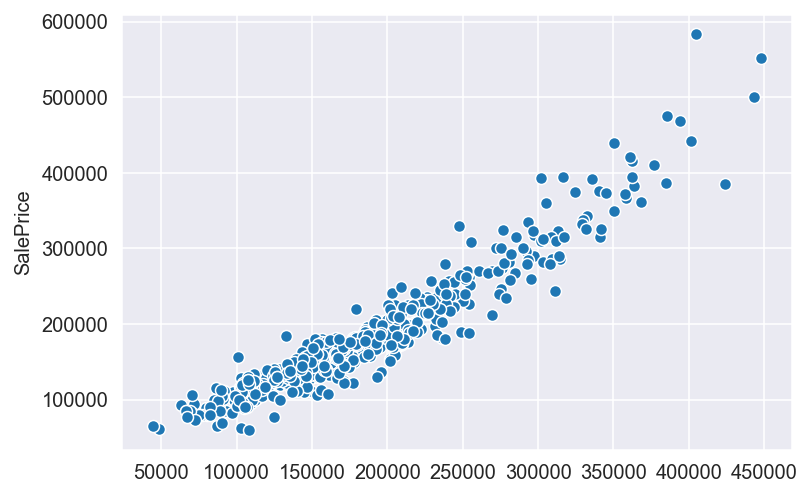

In [44]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_test,y_test)

In [45]:
lasso_model=lasso_model.fit(X,y)

In [46]:
cvs=cross_val_score(lasso_model,X,y,cv=10)
cvs.mean()

0.9056897556836109

In [47]:
lasso_model.intercept_

180350.52484959943

In [48]:
predictions_test=lasso_model.predict(test_sc)

In [49]:
predictions_test.mean()

178490.69951424448

In [50]:
submit=pd.DataFrame()

In [51]:
submit['Id']=test['Id']
submit['SalePrice']=predictions_test
submit=submit.set_index('Id')
submit.to_csv('submit_l1.csv')

In [52]:
submit.describe()

,SalePrice
count,879.000000
mean,178490.699514
std,71579.295803
min,-32079.963622
25%,127778.989839
50%,162106.136079
75%,220602.063735
max,471742.016085


In [53]:
submit.shape

(879, 1)

In [54]:
lasso_model.coef_.shape

(178,)

In [55]:
test.shape

(879, 178)

### Using the coefficients of the lasso_model, we find the features that were used in the model and extract them to reduce the complexity of the model, and export for the next iteration

In [56]:
new_columns=test.columns[[(item>0)for column,item in zip(test.columns,lasso_model.coef_)]]

In [57]:
new_columns

Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Exter Qual',
       'Foundation', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Total Bsmt SF', 'Heating QC', '1st Flr SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Half Bath', 'Kitchen Qual',
       'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Screen Porch SF', 'Land Contour_HLS',
       'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_GrnHill',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition 1_Norm', 'Condition 1_PosA',
       'Condition 1_PosN', 'Condition 2_PosA', 'Roof Style_Hip',
       'Exterior 1st_BrkFace', 'Exterior 1st_CemntBd', 'Mas Vnr Type_Stone',
       'Heating_Wall', 'Misc Feature_Othr', 'Sale Type_Con', 'Sale Type_New'],
      dtype='object')

In [58]:
new_columns=list(new_columns)

In [59]:
new_columns.append('Id')

In [60]:
len(new_columns)

48

In [61]:
train2=pd.DataFrame(train[new_columns])

In [62]:
test2=pd.DataFrame(test[new_columns])

In [63]:
train2['SalePrice']=train['SalePrice']

In [64]:
train2.to_csv('datasets/train_lassoed.csv')

In [65]:
test2.to_csv('datasets/test_lassoed.csv')

In [66]:
train2.shape

(2041, 49)

In [67]:
#train['SalePrice']

In [68]:
#get the polynomial features
target = 'SalePrice'
nc = [x for x in train2.columns if x != target]

X_train,X_test,y_train,y_test=train_test_split(train2[nc],train2[target])

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test= ss.transform(X_test)
#test2=test2.drop('SalePrice',axis=1)
test2_sc=ss.transform(test2)
X=ss.transform(train2[nc])



pf = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
X_train_poly=pf.fit_transform(X_train)
X_test_poly=pf.fit_transform(X_test)
X_train_poly.shape
X_poly=pf.fit_transform(X)
test2_sc_poly=pf.fit_transform(test2_sc)
test_poly_cols=pf.get_feature_names(test2.columns)

In [69]:
X_train.shape

(1530, 48)

In [70]:
X_train_poly.shape

(1530, 1176)

In [71]:
test2_sc_poly.shape

(879, 1176)

In [72]:
l_alphas = np.logspace(2, 6, 100)
#lasso_model = Lasso(alpha=3000,max_iter=10000000)
lasso_model = LassoCV(alphas=l_alphas, cv=10,max_iter=100000, fit_intercept=True)
lasso_model = lasso_model.fit(X_train_poly, y_train)

In [73]:
#cross_val_score(lasso_model,X_train_poly,y_train,cv=5).mean()

In [74]:
lasso_model.alpha_

210.49041445120199

In [75]:
len([column for column,item in zip(test_poly_cols,lasso_model.coef_) if (item>0)])

219

In [76]:
test_predictions=lasso_model.predict(X_test_poly)

0.972461572106062

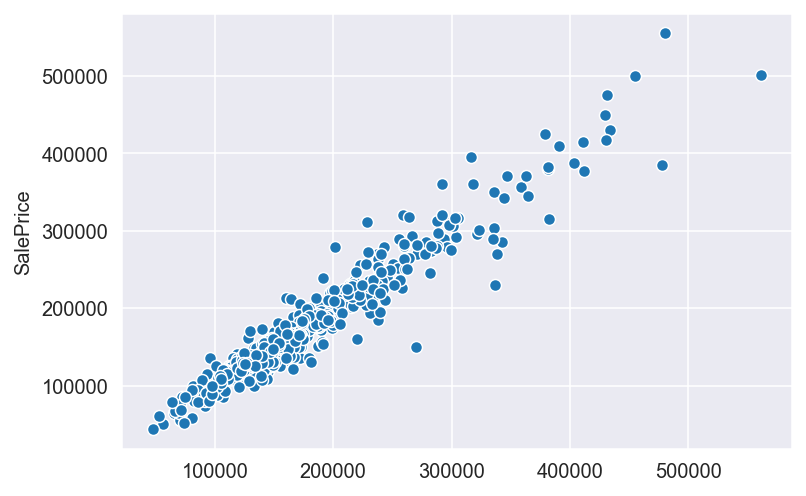

In [77]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_train_poly,y_train)

0.9285035382653208

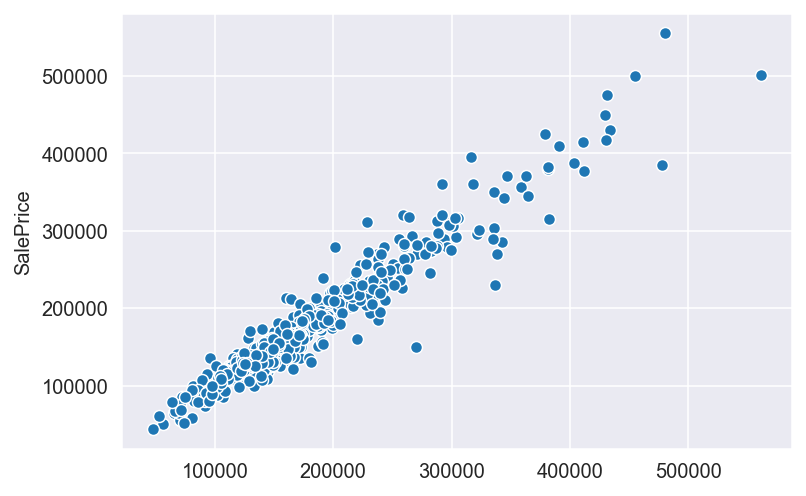

In [78]:
sns.scatterplot(test_predictions,y_test)
lasso_model.score(X_test_poly,y_test)

In [79]:
lasso_model.intercept_

171815.5820553057

In [80]:
pd.set_option('display.max_columns', 100)

In [81]:
predictions_test=lasso_model.predict(test2_sc_poly)

In [82]:
submit['Id']=list(test2['Id'])
submit['SalePrice']=predictions_test
submit=submit.set_index('Id')
submit.to_csv('submissions/dll.csv')

In [83]:
submit.head()

,SalePrice
Id,
2658,156305.781264
2718,163374.968060
2414,191865.138932
1989,105950.563857
625,171051.380859


In [84]:
new_columns=[column for column,item in zip(test_poly_cols,lasso_model.coef_) if (item>0)]

In [85]:
len(new_columns)

219

In [86]:
new_train=pd.DataFrame(X_poly,columns=test_poly_cols)
new_train=new_train[new_columns]
new_train['SalePrice']=train['SalePrice']

In [87]:
new_test=pd.DataFrame(test2_sc_poly,columns=test_poly_cols)
new_test=new_test[new_columns]
new_test['SalePrice']=np.zeros(shape=(879,))


In [88]:
new_test.to_csv('datasets/lltest.csv')
new_train.to_csv('datasets/lltest.csv')